In [193]:
import pydicom
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt
import cv2
import os
import shutil
from IPython.display import clear_output
from random import sample
import scipy
import skimage
import random
import math

In [194]:
#What Folder are you using?
#From the folder this notebook is in Ex: mainFolder = "data/train"
#DONT ADD A '/' at the end please
mainFolder = "split/train"
namesOfFolder = ["atypical", "indeterminate", "negative", "typical"]
tempTrainArray = []
tempTrainLabel = []

In [195]:
def get_names(path):
    names = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.dcm']:
                names.append(filename)
    
    return names

In [196]:
def get_names_PNG(path):
    names = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.png']:
                names.append(filename)
    
    return names

In [197]:
def get_names_dup(path):
    names = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            other, ext = os.path.splitext(filename)
            #print(other)
            if str(other).find('-dup') != -1:
                names.append(filename)
    
    return names

In [198]:
def clearDups(folder):
    namesOfFolder = ["atypical", "indeterminate", "negative", "typical"]
    amountOfFiles = np.array([len(get_names(mainFolder + "/" + namesOfFolder[0])),len(get_names(mainFolder + "/" + namesOfFolder[1])), len(get_names(mainFolder + "/" + namesOfFolder[2])), len(get_names(mainFolder + "/" + namesOfFolder[3]))])
    counter = 0
    for k in amountOfFiles:
        if k != 0:
            for x in get_names_dup(folder + "/" +namesOfFolder[counter]):
                os.remove(folder + "/" + namesOfFolder[counter] + "/" + x)
        counter += 1

In [199]:
clearDups(mainFolder)

In [200]:
#Number of dups should be 0 if not please use the clearDups function
print("Number of duplicates:", len(get_names_dup(mainFolder)))
print("Size of "+ namesOfFolder[0], len(get_names(mainFolder + "/" + namesOfFolder[0])))
print("Size of "+ namesOfFolder[1], len(get_names(mainFolder + "/" + namesOfFolder[1])))
print("Size of "+ namesOfFolder[2], len(get_names(mainFolder + "/" + namesOfFolder[2])))
print("Size of "+ namesOfFolder[3], len(get_names(mainFolder + "/" + namesOfFolder[3])))
print("Total Size of " + mainFolder, len(get_names(mainFolder)))

Number of duplicates: 0
Size of atypical 102
Size of indeterminate 164
Size of negative 197
Size of typical 94
Total Size of split/train 557


In [201]:
amountOfFiles = np.array([len(get_names(mainFolder + "/" + namesOfFolder[0])),len(get_names(mainFolder + "/" + namesOfFolder[1])), len(get_names(mainFolder + "/" + namesOfFolder[2])), len(get_names(mainFolder + "/" + namesOfFolder[3]))])
if len(np.where(amountOfFiles == amountOfFiles.min())[0]) > 1:
    smallestFolder = int(np.where(amountOfFiles == amountOfFiles.min())[0][0])
else:    
    smallestFolder = int(np.where(amountOfFiles == amountOfFiles.min())[0])

print("The Folder to double and set normalize to: ", namesOfFolder[smallestFolder], " From ", amountOfFiles[smallestFolder], " files to ", 2 * amountOfFiles[smallestFolder], " files")

normalizeTo = 2 * amountOfFiles[smallestFolder]


The Folder to double and set normalize to:  typical  From  94  files to  188  files


In [202]:
def convert_dcm_npy(name, directory, label):
    
    i = pydicom.dcmread(directory+'/'+name)
    
    im = i.pixel_array.astype(float)
    
    rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
    
    final_image = np.uint8(rescaled_image) # integers pixels

    final_image = Image.fromarray(final_image)
    
    doo = final_image.convert('RGB')
    
    foo = np.asarray(doo)
    
    return (foo, label)

In [203]:
def convert_dcm_npyNotFilling(name, directory, label):
    
    i = pydicom.dcmread(directory+'/'+name)
    
    im = i.pixel_array.astype(float)
    
    rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
    
    final_image = np.uint8(rescaled_image) # integers pixels

    final_image = Image.fromarray(final_image)
    
    doo = final_image.convert('RGB')
    
    foo = np.asarray(doo)
    
    return (foo, label)

In [204]:
def rotateCroppedImage(rotated_Image, width, height):
    image_size = (rotated_Image.shape[1], rotated_Image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return rotated_Image[y1:y2, x1:x2]

In [205]:
def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

In [206]:
def fillingFile(folder, files, counter, label):
        print("duplicating " + files[counter] + ".....")
        #shutil.copy(folder + "/"  + files[counter], folder + "/"+ files[counter].replace('.dcm','-dup.dcm'))
        
        img = convert_dcm_npy(files[counter], folder, label)
        #ds = pydicom.read_file(folder + "/"+ files[counter])
        #img = ds.pixel_array
        #imgRGB = skimage.color.gray2rgb(img)
        rotationAngle = random.uniform(-4, 4)   
        img_10 = scipy.ndimage.rotate(img[0], rotationAngle, reshape=False)
        image_rotated_cropped = rotateCroppedImage(img_10, *largest_rotated_rect(img_10.shape[0],img_10.shape[0], math.radians(rotationAngle)))
        iresized = skimage.transform.resize(image_rotated_cropped, (299, 299), anti_aliasing=True)
        image_scaled = ((iresized - iresized.min()) * (1/(iresized.max() - iresized.min()) * 255)).astype('uint8')
        clear_output()
        plt.imshow(image_scaled)
        plt.show()
        print("duplicated " + files[counter] + " to " + files[counter].replace('.dcm','-dup.dcm'))
        
        return image_scaled

In [207]:
def cullingFile(folder, files, counter):
    print("culling " + files[counter] + ".....")

    os.remove(folder + "/" + files[counter])
    print("culled " + files[counter])
    clear_output(wait=True)

In [208]:
def doubleFolder(folder, label):
    
    temptempArray = []
    temptempLabelArray = []
    
    listToDouble = get_names(folder)
    
    for x in listToDouble:
        if "-dup" in listToDouble:
            print("Error Dupliate in Folder!")
            exit(1)
    
    print(listToDouble)
    for file in listToDouble:
        try:
            print("duplicating " + file + ".....")
            
            img = convert_dcm_npy(file, folder, label)
            rotationAngle = random.uniform(-4, 4)
            img_10 = scipy.ndimage.rotate(img[0], rotationAngle, reshape=False)
            
            
            image_rotated_cropped = rotateCroppedImage(img_10, *largest_rotated_rect(img_10.shape[0],img_10.shape[0], math.radians(rotationAngle)))
            iresized = skimage.transform.resize(image_rotated_cropped, (299, 299), anti_aliasing=True)
            image_scaled = ((iresized - iresized.min()) * (1/(iresized.max() - iresized.min()) * 255)).astype('uint8')
            plt.imshow(image_scaled)
            plt.show()
            temptempArray.append(image_scaled)
            temptempLabelArray.append(img[1])
               
            #shutil.copy(folder + "/"+ file, folder + "/"+ file.replace('.dcm','-dup.dcm'))
            print("duplicated " + file + " to " + file.replace('.dcm','-dup.dcm'))
            clear_output(wait=True)
        except IOError:
            print ('Error while copying files !!!')
    #clear_output()
    print("Done!")
    
    return temptempArray, temptempLabelArray
    
    

In [209]:
#doubling folder
subtempArray, subtempLabelArray = doubleFolder(mainFolder + "/" + namesOfFolder[smallestFolder], smallestFolder)

counter = 0
for l in subtempArray:
    tempTrainArray.append(l)
    counter += 1
l = []
for m in subtempLabelArray:
    tempTrainLabel.append([m])
    
print("Doubled the folder", namesOfFolder[smallestFolder], "to create", counter, "files")
subtempArray = []
subtempLabelArray = []

Done!
Doubled the folder typical to create 94 files


In [210]:
#Sanity Check
print("Size of "+ namesOfFolder[0], len(get_names(mainFolder + "/" + namesOfFolder[0])))
print("Size of "+ namesOfFolder[1], len(get_names(mainFolder + "/" + namesOfFolder[1])))
print("Size of "+ namesOfFolder[2], len(get_names(mainFolder + "/" + namesOfFolder[2])))
print("Size of "+ namesOfFolder[3], len(get_names(mainFolder + "/" + namesOfFolder[3])))
print("")
print("Length of tempArray:", len(tempTrainArray))
print("Length of tempLabelArray:", len(tempTrainLabel))
print(np.asarray(tempTrainArray[0]).min())
print(np.asarray(tempTrainArray[0]).max())

Size of atypical 102
Size of indeterminate 164
Size of negative 197
Size of typical 94

Length of tempArray: 94
Length of tempLabelArray: 94
0
255


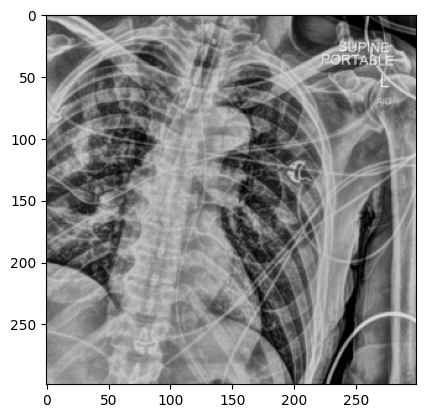

duplicated 419639-001012_indeterminate_2.dcm to 419639-001012_indeterminate_2-dup.dcm
Added to split/train/indeterminate
All Done!


In [211]:
#Filling


array = [smallestFolder]
for i in range(len(namesOfFolder)):
    toBeFilled = mainFolder + "/" + namesOfFolder[i]
    if i != smallestFolder and amountOfFiles[i] < (2 * amountOfFiles[smallestFolder]):
        array.append(i)
        orginalFiles = get_names(toBeFilled)
        print("Currently filling:", toBeFilled)
        
        
        
        amountToFill = normalizeTo - len(orginalFiles)
            
        
        for j in range(amountToFill):
            tempTrainArray.append(fillingFile(toBeFilled, orginalFiles, j, namesOfFolder[i]))
            tempTrainLabel.append([i])
        print("Added", "to", toBeFilled)
        #counter = 0    
        #while(len(get_names(toBeFilled)) != (2 * amountOfFiles[smallestFolder])):
        
            #fillingFile(toBeFilled, orginalFiles, counter)
            #counter += 1
    
        
#clear_output()
print("All Done!")

In [212]:
#Sanity Check
print("Size of "+ namesOfFolder[0], len(get_names(mainFolder + "/" + namesOfFolder[0])))
print("Size of "+ namesOfFolder[1], len(get_names(mainFolder + "/" + namesOfFolder[1])))
print("Size of "+ namesOfFolder[2], len(get_names(mainFolder + "/" + namesOfFolder[2])))
print("Size of "+ namesOfFolder[3], len(get_names(mainFolder + "/" + namesOfFolder[3])))
print("")
print("Length of tempArray:", len(tempTrainArray))
print("Length of tempLabelArray:", len(tempTrainLabel))



Size of atypical 102
Size of indeterminate 164
Size of negative 197
Size of typical 94

Length of tempArray: 204
Length of tempLabelArray: 204


In [213]:
#print(np.asarray(tempTrainArray).dtype)
#print(np.asarray(tempTrainLabel).dtype)

#testing = convert_dcm_npyNotFilling("175.dcm", mainFolder + "/" + "atypical", namesOfFolder.index("atypical"))

#print([testing[1]])
#print(image[1])

In [214]:
clearDups(mainFolder)

In [215]:
#Sanity Check
print("Size of "+ namesOfFolder[0], len(get_names(mainFolder + "/" + namesOfFolder[0])))
print("Size of "+ namesOfFolder[1], len(get_names(mainFolder + "/" + namesOfFolder[1])))
print("Size of "+ namesOfFolder[2], len(get_names(mainFolder + "/" + namesOfFolder[2])))
print("Size of "+ namesOfFolder[3], len(get_names(mainFolder + "/" + namesOfFolder[3])))
print("")
print("Length of tempArray:", len(tempTrainArray))
print("Length of tempLabelArray:", len(tempTrainLabel))

Size of atypical 102
Size of indeterminate 164
Size of negative 197
Size of typical 94

Length of tempArray: 204
Length of tempLabelArray: 204


In [216]:

maxArray = [0, 1, 2, 3]
leftOverArray = [x for x in maxArray if x not in array]
#print(leftOverArray)
#Culling
for p in leftOverArray:
    
    toBeCulled = mainFolder + "/" + namesOfFolder[p]
    #while not less then (2 * amountOfFiles[smallestFolder])
    
    toBeShuffled = get_names(toBeCulled)
    sufflednames = sample(toBeShuffled, len(toBeShuffled))
    #print((len(get_names(toBeCulled))))
    #print((2 * amountOfFiles[smallestFolder]))
    counter = 0
    #amountToFill = normalizeTo - len(toBeShuffled)
    while(len(get_names(toBeCulled)) != (2 * amountOfFiles[smallestFolder])):
        #randomly delete file
        #print("hello")
        cullingFile(toBeCulled,sufflednames, counter)
        counter += 1
clear_output()
print("Done!")

    


Done!


In [217]:
#Sanity Check
print("Size of "+ namesOfFolder[0], len(get_names(mainFolder + "/" + namesOfFolder[0])))
print("Size of "+ namesOfFolder[1], len(get_names(mainFolder + "/" + namesOfFolder[1])))
print("Size of "+ namesOfFolder[2], len(get_names(mainFolder + "/" + namesOfFolder[2])))
print("Size of "+ namesOfFolder[3], len(get_names(mainFolder + "/" + namesOfFolder[3])))

Size of atypical 102
Size of indeterminate 164
Size of negative 188
Size of typical 94


# DO SEPERATLY

In [218]:
import skimage
import io

In [219]:
totalArray = []
labelArray = []
for x in range(len(tempTrainArray)):
    totalArray.append(tempTrainArray[x])
    
for y in range(len(tempTrainLabel)):
    #print(tempTrainLabel[y])
    labelArray.append(tempTrainLabel[y])

tempTrainArray = []
tempTrainLabel = []

#names = get_names(directoryToConvert)


In [220]:
directoryToConvert = "split/train"
namesOfFolder = ["atypical", "indeterminate", "negative", "typical"]
for folder in namesOfFolder:
    names = get_names( directoryToConvert + "/" + folder)
    for name in names:
    
        image = convert_dcm_npyNotFilling(name, directoryToConvert + "/" + folder, namesOfFolder.index(folder))
        img = skimage.transform.resize(image[0], (299, 299), anti_aliasing=True)
        image_scaled = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
        newName = name[:-4]
        
        totalArray.append(image_scaled)
        labelArray.append([image[1]])

In [221]:
train_image_arrays = np.asarray(totalArray, dtype =  np.uint8)
train_labels = np.asarray(labelArray, dtype= np.uint32)

np.save('train_image_arrays.npy', train_image_arrays)
np.save('train_labels.npy', train_labels)



In [222]:
train_image_arrays = []
train_labels = []
totalArray = []
labelArray = []

In [223]:
directoryToConvert = 'split/test'
namesOfFolder = ["atypical", "indeterminate", "negative", "typical"]
#names = get_names(directoryToConvert)

testArray = []
testLabelArray = []
for folder in namesOfFolder:
    names = get_names( directoryToConvert + "/" + folder)
    for name in names:
    
        image = convert_dcm_npyNotFilling(name, directoryToConvert + "/" + folder, namesOfFolder.index(folder))
        img = skimage.transform.resize(image[0], (299, 299), anti_aliasing=True)
        image_scaled = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
        newName = name[:-4]
        #print(newName)
        #print(image.shape)
        #plt.imshow(image)
        #plt.show()
        
        testArray.append(image_scaled)
        testLabelArray.append([image[1]])
        
        

    


test_image_arrays = np.asarray(testArray, dtype = np.uint8)
test_labels = np.asarray(testLabelArray,dtype= np.uint32)

np.save('test_image_arrays.npy', test_image_arrays)
np.save('test_labels.npy', test_labels)



In [224]:
testArray = []
testLabelArray = []
test_image_arrays = []
test_labels = []